# Setups of Noisy Labels

Throughout this section, you will get familiar with:

* What are noisy labels?

* How do we characterize noisy labels?

* How do we simulate noisy labels for controlled experiments?

## 1. What are noisy labels?

* Given an instance $(X,Y)$, where $X$ is the feature, $Y$ is the clean/true label.
* A noisy label $\widetilde Y$ may or may not be the same as the true label.

<img src="tutorial_imgs/label_noise.png" width="1000"> 

## 2. How noisy is the data?

**Statistical measure: Label noise transition matrix**


### General: Instance-dependent label noise

**Instance-dependent label noise transition matrix $T(X)$** 
* Different matrices for different feature $X$
* Each element $T_{ij}(X)$: Flipping probability the clean label $Y=i$ $\rightarrow$ the noisy label $\widetilde{Y} = j$, given feature $X$

$$
T_{ij}(X)=\mathbb P(\widetilde{Y}=j|Y=i,X).
$$

### Simplified: Class-dependent label noise

**Class-dependent label noise transition matrix $T$**
* Assume $T(X) = T, \forall X$
* Each element $T_{ij}$: Flipping probability the clean label $Y=i$ $\rightarrow$ the noisy label $\widetilde{Y} = j$


### Intuitions:
* Capture random, averaged flipping errors
* Enable more possibilities of theoretical analyses

Remembering the previous illustration figure, we could derive a rough estimate that:

<img src="./tutorial_imgs/label_noise_cut.png" width="700"> 

$
\mathbf{P}(\widetilde{Y} = \text{dog}| Y = \text{cat}) = 1/10 = 0.1
$

$
\mathbf{P}(\widetilde{Y} = \text{cat}| Y = \text{cat}) = 7/10 = 0.7
$

### Importance of $T$

* Understanding the pattern/structure of label noise
* Design robust loss functions
* Helps label aggregation (weighted majority vote)

#### Importance 1: Understand the pattern of label noise
**Examples from CIFAR-10N**

* CIFAR-10N: 
  * 10 classes. 
  * Each image is annotated by 3 independent human workers.
* Aggregation labels: 
  * Take the majority vote from 3 annotations.
  * Break ties evenly.

<table>
  <tr>
    <td ><img src="./tutorial_imgs/c10_agg.png" width="800"> 

    Figure: Label noise transition matrix of CIFAR-10N.
</td>
    <td>
    * Humans can be very accurate on some classes (ship 97%, horse 96%)<br/>
    * Humans can be inaccurate on other classes (cat 83%, deer 83%)<br/>
    * Human annotations have bias:<br/>
      &nbsp;&nbsp;&nbsp;&nbsp;- Horse-deer is a pair with high similarity, <b>but</b>..<br/>
      &nbsp;&nbsp;&nbsp;&nbsp;- Humans tend to annotate deer as horse: deer &rarr; horse 0.04<br/>
      &nbsp;&nbsp;&nbsp;&nbsp;- Humans tend <b>not</b> to annotate horse as deer: horse &rarr; deer 0.01 <br/>
    </td>
  </tr>
</table> 

**Examples from CIFAR-100N**

* CIFAR-100N: 
  * 20 coarse classes, 100 fine classes. Each coarse class contains 5 fine classes.
  * The human workers are asked to annotate the fine classes for each image (choose one class from the pool of 100 labels).
  * Each image is annotated by only one human worker
  * The following T shows the transition between coarse labels


<table>
  <tr>
    <td ><img src="tutorial_imgs/c100_coarse.png" width="1100"> 

    Figure: Label noise transition matrix of CIFAR-100N.
</td>
    <td>
    * Humans can be very accurate on some classes<br/>
      &nbsp;&nbsp;&nbsp;&nbsp;- people 94%<br/>
    * Humans can be inaccurate on other classes <br/>
      &nbsp;&nbsp;&nbsp;&nbsp;- medium-sized mammals 47%<br/>
    * Human annotations have bias:<br/>
      &nbsp;&nbsp;&nbsp;&nbsp;- man-made &rarr; natural 0.09<br/>
      &nbsp;&nbsp;&nbsp;&nbsp;- natural &rarr; man-made 0.03 <br/>
    </td>
  </tr>
</table> 

#### Importance 2: Design robust loss functions

Recall that:
* Feature $X$, noisy label $\widetilde Y$. 
* Model: $\bm f(\cdot)$ (Input: $X$, output: a column vector, probability of predicting each label class)
* Loss function: $\ell$.
* Label noise transition matrix $\bm T$, and its transpose $\bm T^\top$.

#### Forward loss correction:
$$
\ell^{\rightarrow}(\bm f(X),\widetilde Y):= \ell(\bm T^\top \bm f(X),\widetilde Y).
$$

#### Importance 3 Helps label aggregation (weighted majority vote)

Intuition:
* Normal majority vote: each labeler has the same weight. 
  * E.g., $\text{MV}(1,1,0) = 1$.
* Weighted majority vote: each labeler makes mistakes with some probability. 
  * E.g., 
    * label class 1 is rare, 
    * clean 1 --> noisy 1 is likely to make mistakes
    * ==> we may have $\text{MV}_\text{Weighted}(1,1,0) = 0$.
  * Condition:  
    * $\mathbb P(Y=1) = 0.2, $ 
    * $T = \begin{pmatrix} 0.8 & 0.2 \\ 0.7 & 0.3 \end{pmatrix}  $
  * Probability of label 1: $$   \begin{align*} & \mathbb P(Y=1| \widetilde Y_1 = 1, \widetilde Y_2 = 1, \widetilde Y_3 = 0)  \\ = & \frac{\mathbb P(Y=1)}{\mathbb P( \widetilde Y_1 = 1, \widetilde Y_2 = 1, \widetilde Y_3 = 0)} \cdot \mathbb P(\widetilde Y_1=1|Y=1) \cdot \mathbb P(\widetilde Y_2=1|Y=1) \cdot \mathbb P(\widetilde Y_3=0|Y=1) \\ = & \frac{0.0126}{\mathbb P( \widetilde Y_1 = 1, \widetilde Y_2 = 1, \widetilde Y_3 = 0)}\end{align*}  $$
  * Probability of label 0: $$   \begin{align*} & \mathbb P(Y=0| \widetilde Y_1 = 1, \widetilde Y_2 = 1, \widetilde Y_3 = 0)  \\ = & \frac{\mathbb P(Y=0)}{\mathbb P( \widetilde Y_1 = 1, \widetilde Y_2 = 1, \widetilde Y_3 = 0)} \cdot \mathbb P(\widetilde Y_1=1|Y=0) \cdot \mathbb P(\widetilde Y_2=1|Y=0) \cdot \mathbb P(\widetilde Y_3=0|Y=0) \\ = & \frac{0.0256}{\mathbb P( \widetilde Y_1 = 1, \widetilde Y_2 = 1, \widetilde Y_3 = 0)} \end{align*} $$
  
 

## 3. How can we simulate label noise?

* **Symmetric noise** 
    * Same noise rate, even flipping. 
    * E.g., $T=\begin{pmatrix}0.8 & 0.1 & 0.1 \\ 0.1 & 0.8 & 0.1 \\ 0.1 & 0.1 & 0.8\end{pmatrix}$
  
* **Asymmetric noise (Pairflip)** 
    * Flip only to the next label class, e.g., 1-->2, 2-->3, 3-->1
    * E.g., $T=\begin{pmatrix}0.8 & 0.2 & 0.0 \\ 0.0 & 0.8 & 0.2 \\ 0.2 & 0.0 & 0.8\end{pmatrix}$
  
* **Random noise** 
    * A random $T$
    * E.g., $T=\begin{pmatrix}0.7 & 0.2 & 0.1 \\ 0.2 & 0.6 & 0.2 \\ 0.2 & 0.3 & 0.5\end{pmatrix}$
### Simulation of class-dependent label noise

In [1]:
import numpy as np
from numpy.testing import assert_array_almost_equal
def multiclass_noisify(y, T, random_state=0):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.
    """

    # T must satisfy the following four properties:
    assert T.shape[0] == T.shape[1]  # requires a square matrix
    assert np.max(y) < T.shape[0]    # E.g., 3-class classifications, np.max(y)<=2, T.shape[0]=3.
    assert_array_almost_equal(T.sum(axis=1), np.ones(T.shape[1])) # row sum should be 1
    assert (T >= 0.0).all()  # non-negative

    m = y.shape[0]
    noisy_y = y.copy()
    flipper = np.random.RandomState(random_state)

    for idx in np.arange(m):
        i = y[idx] # clean label
        flipped = flipper.multinomial(1, T[i, :], 1)[0] # take the i-th row from T, draw a vector according to the probability
        noisy_y[idx] = np.where(flipped == 1)[0] # noisy label

    return noisy_y

### Example:

**A Toy Example**
* Synthesize a dataset of 4,000 instances
* Binary classification
* Each instance has three noisy labels (given by three independent labeler)

In [9]:
# Set the label noise transition matrix T
import numpy as np
np.random.seed(0)
num_samples = 4000

# Set the label transition matrix T
T = np.array([
    [0.6, 0.4],
    [0.2, 0.8],
])

# Set the clean label distribution p
p = [0.3, 0.7]

# Generate clean labels
clean_labels = np.array([0] * int(num_samples * p[0]) + [1] * (num_samples - int(num_samples * p[0])))
np.random.shuffle(clean_labels)

# Generate three noisy labels
noisy_labels_1 = multiclass_noisify(clean_labels, T, random_state=1)
noisy_labels_2 = multiclass_noisify(clean_labels, T, random_state=2)
noisy_labels_3 = multiclass_noisify(clean_labels, T, random_state=3)
noisy_labels = [[noisy_labels_1[i], noisy_labels_2[i], noisy_labels_3[i]] for i in range(len(clean_labels))] # restructure

print(noisy_labels[:5])


[[1, 1, 1], [1, 0, 1], [1, 1, 1], [1, 1, 1], [0, 0, 1]]


In [10]:
# Get the true T
true_T = np.zeros((2,2))
true_p = np.zeros(2)
for i in range(len(clean_labels)):
    for j in range(len(noisy_labels[0])):
        true_T[clean_labels[i]][noisy_labels[i][j]] += 1
    true_p[clean_labels[i]] += 1
true_T /= np.sum(true_T, 1).reshape(-1,1)
true_p /= np.sum(true_p)

# Set precisions
np.set_printoptions(precision=3)

# Print the True T and p
print(f"The true T is:\n{true_T}")
print(f"The true p is:\n{true_p}")
np.save("./data/clean_labels.npy", clean_labels)
np.save("./data/noisy_labels.npy", noisy_labels)

The true T is:
[[0.611 0.389]
 [0.203 0.797]]
The true p is:
[0.3 0.7]


### 3. Coding section
[TODO] move to Jiaheng's part?

Load required libraries

In [3]:
import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from data.cifar import CIFAR10
from data.datasets import input_dataset
from models import *
import argparse, sys
import numpy as np
import datetime
import shutil
from random import sample 
from loss import loss_gls
from torch.utils.data import RandomSampler

Parameter settings

In [4]:
args = {'noise_rate': 0.2, 'noise_type': 'symmetric', 'seed': 0, 'dataset': 'cifar10'}
# Noise type choices: pairflip, symmetric

In [5]:
torch.manual_seed(args['seed'])
# Hyper Parameters
batch_size = 128
n_type = args['noise_type']
# load dataset
train_dataset, vis_train_dataset, test_dataset,num_classes,num_training_samples = input_dataset(args['dataset'],args['noise_type'],args['noise_rate'])


KeyboardInterrupt: 

Take a look at the transition matrix $T$

In [ ]:
def compute_matrix(y_clean, y_noisy):
    # Initialize 10*10 matrix with zeros
    wid = len(np.unique(train_dataset.train_labels))
    matrix = np.zeros((wid, wid))

    for i in range(len(y_clean)):
        # Increment the corresponding matrix cell by 1
        matrix[y_clean[i], y_noisy[i]] += 1
    
    # Sum each row and reshape the result for broadcasting division
    row_sums = matrix.sum(axis=1).reshape(-1, 1)
    
    # Avoid division by zero by replacing zero sums with 1
    row_sums[row_sums == 0] = 1

    normalized_matrix = np.round(matrix / row_sums, 3)
    return normalized_matrix
print(compute_matrix(train_dataset.train_labels, train_dataset.train_noisy_labels))

[[0.8   0.02  0.024 0.021 0.023 0.025 0.022 0.022 0.022 0.022]
 [0.022 0.799 0.023 0.021 0.023 0.023 0.02  0.023 0.021 0.025]
 [0.021 0.023 0.801 0.022 0.02  0.022 0.026 0.022 0.022 0.022]
 [0.023 0.025 0.023 0.795 0.024 0.021 0.02  0.021 0.025 0.023]
 [0.021 0.025 0.021 0.018 0.805 0.022 0.021 0.022 0.023 0.021]
 [0.02  0.023 0.029 0.025 0.023 0.789 0.021 0.023 0.027 0.02 ]
 [0.019 0.017 0.023 0.02  0.022 0.02  0.804 0.026 0.021 0.027]
 [0.021 0.024 0.019 0.022 0.022 0.023 0.024 0.8   0.025 0.019]
 [0.023 0.026 0.019 0.022 0.022 0.021 0.022 0.024 0.796 0.024]
 [0.02  0.022 0.023 0.025 0.022 0.021 0.02  0.019 0.022 0.805]]


Visualize some example images with clean and synthetic noisy labels

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
txt_classes = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}
    
def transform(img):
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))
    # return npimg

def visualize(idxs, data, is_human=True):
    data_subset = torch.utils.data.Subset(data, idxs)
    plt.rcParams["figure.figsize"] = (9,7)
    noise_file = torch.load('./data/CIFAR-10_human.pt')
    human_noise = noise_file['worse_label']
    for i in range(15):
        # print(dataset[i])
        X,y, idx = data_subset[i]
        ax = plt.subplot(3,5,i+1)
        if is_human:
            noisy_label = txt_classes[int(human_noise[i])]
        else:
            noisy_label = txt_classes[int(y)]
        clean_label = txt_classes[int(train_dataset.train_labels[idx])]
        ax.set_title(f"Clean: {clean_label}\n Noisy: {noisy_label}")
        ax.imshow(transform(X))
        ax.axis('off')
    plt.show()

Visualize real-world human noise

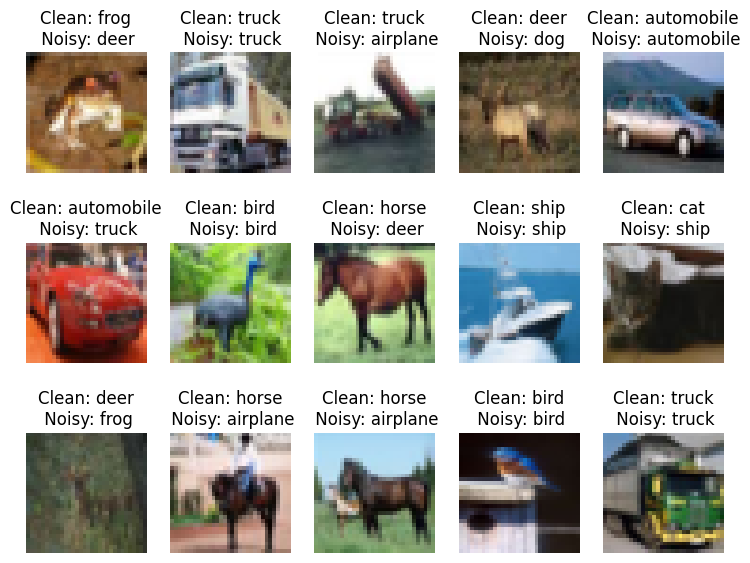

In [ ]:
visualize(range(15), vis_train_dataset, is_human=True)